In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import time
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from matplotlib.ticker import FormatStrFormatter

In [2]:
#2)Base Import
datestack=pd.read_csv('A:\Git\FX_Data\datestack.csv')
datestack=datestack['Date'].apply(pd.to_datetime)

def import_data(data_table):
    conn=sqlite3.connect('A:\Git\Data\FX_Data.db')
    df=pd.read_sql_query("""
    SELECT * from {}
    ORDER BY Time ASC;    
    """.format(data_table),conn)
    return df

In [3]:
#Setting up initial 1 hr frame with 25 day rolling ADR
h1=import_data('H1_EUR_USD')
h1['Time']=pd.to_datetime(h1['Time'])
#appending grouped daily columns as well
h1['Daily']=pd.to_datetime(h1['Time'].apply(lambda x: '{}-{}-{}'.format(x.year,x.month,x.day)))

#Daily frame
d1=pd.DataFrame()
d1=pd.DataFrame(data=h1['Daily']).drop_duplicates().reset_index(drop=True)
d1['Open']=h1.groupby(['Daily']).Open.first().rename('temp').reset_index(drop=True)
d1['High']=h1.groupby(['Daily']).High.max().rename('temp').reset_index(drop=True)
d1['Low']=h1.groupby(['Daily']).Low.min().rename('temp').reset_index(drop=True)
d1['Close']=h1.groupby(['Daily']).Close.last().rename('temp').reset_index(drop=True)

#creating ADR
d1['Range']=d1.High-d1.Low
d1['ADR']=d1['Range'].rolling(25).mean().shift(1)
d1['ADR_min']=round(d1['ADR']/2,5)

#add daily ADR to hourly df
h1=pd.merge(h1,d1[['Daily','ADR','ADR_min']],on='Daily')

In [4]:
#to view in Excel
def export(base_df,name):
    writer = pd.ExcelWriter('A:\Git\FX_Data\Excel_Exports\swing_extract{}.xlsx'.format(name))
    base_df.to_excel(writer, index=False, sheet_name='extract')
    writer.save()
        
#classifying waves        
def TESF(df):
    #Get TESF for all swings
    for i in df.index:
        #exclude the first couple swings
        if i>3:
            p1=df.loc[i-3,"Swing_Price"]
            p2=df.loc[i-2,"Swing_Price"]
            p3=df.loc[i-1,"Swing_Price"]
            p4=df.loc[i,"Swing_Price"]
            if p4>=p2>=p3>=p1:
                swing_type="T"
            elif p2>=p4>=p3>=p1:
                swing_type="F"
            elif p4>=p2>=p1>=p3:
                swing_type="E"
            elif p2>p1>p3 and p2>p4>p3:
                swing_type="S"
            elif p1>=p3>=p2>=p4:
                swing_type="T"
            elif p1>=p3>=p4>=p2:
                swing_type="F"
            elif p3>=p1>=p2>=p4:
                swing_type="E"
            elif p3>p1>p2 and p3>p4>p2:
                swing_type="S"
            else:
                swing_type="??"
            df.loc[i,"Swing_Type"]=swing_type
    return df

#Extra Functions
def retracement(H,L,P):
    if (H-L)==0:return 0
    R=(P-L)/(H-L)
    return R

def calc_retracement(df):
    #only takes a df that has only TESF swings
    # work_swings=all_swings
    for i in range(2,len(df)):
        if df.loc[i,'Fractal']=="T":
            a=df.loc[df.loc[i-2,'id'],'High']
            b=df.loc[df.loc[i-1,'id'],'Low']
            c=df.loc[df.loc[i,'id'],'High']
            df.loc[i,'Retracement']=retracement(a,b,c)
        elif df.loc[i,'Fractal']=="B":
            a=df.loc[df.loc[i-2,'id'],'Low']
            b=df.loc[df.loc[i-1,'id'],'High']
            c=df.loc[df.loc[i,'id'],'Low']
            df.loc[i,'Retracement']=retracement(a,b,c)                        
    return df

In [5]:
def find_first_direction(row_number,df):
    direction = None
    for i in range(row_number,len(df)-1):
        max_current_range=df.loc[row_number:i,'High'].max()-df.loc[row_number:i,'Low'].min()
        if direction == 'up' or direction == 'down':
            break
        elif max_current_range>=df.loc[i,'ADR_min']:
            if df.loc[i,'High'] == df.loc[row_number:i,'High'].max():
                direction = 'up'
                row_return=i
                break
            if  df.loc[i,'Low'] == df.loc[row_number:i,'Low'].min():
                direction = 'down'
                row_return=i
                break
            else:
                print('error')
    print(df.loc[i,'Time'])
    return direction,row_return

In [6]:
def find_next_low(row_number,df):
    direction,max_high,iterator = 'up',0,0
    moving_row_number=row_number
    while iterator <= len(df)-1:
        if direction == 'down':
            break

        for i in range(moving_row_number,len(df)):
            iterator=i
            max_current_range=df.loc[moving_row_number:i,'High'].max()-df.loc[moving_row_number:i,'Low'].min()
            if direction == 'down':
                break

            elif max_current_range>=df.loc[i,'ADR_min']:
                if (df.loc[moving_row_number:i,'High'].idxmax() > df.loc[moving_row_number:i,'Low'].idxmin()):
                    moving_row_number=i
                    break
                elif (df.loc[moving_row_number:i,'Low'].idxmin()>df.loc[moving_row_number:i,'High'].idxmax()):
                    direction = 'down'
                    max_high=df.loc[moving_row_number:i,'High'].idxmax()
                    row_return=i
                    break

            elif i >= (len(df)-1):
                direction = 'down'
                max_high=df.loc[row_number:row_number+i,'Low'].idxmin()
                row_return=(len(df)-1)
                break
    if iterator >= len(df)-1:
        row_return = moving_row_number+iterator
    return direction,max_high,row_return

def find_next_high(row_number,df):
    direction,min_low,iterator = 'down',0,0
    moving_row_number=row_number
    while iterator < len(df)-1:
        if direction == 'up':
            break
        for i in range(moving_row_number,len(df)):
            iterator=i
            max_current_range=df.loc[moving_row_number:i,'High'].max()-df.loc[moving_row_number:i,'Low'].min()            
            if direction == 'up':
                break
                
            elif max_current_range>=df.loc[i,'ADR_min']:
                if (df.loc[moving_row_number:i,'Low'].idxmin() > df.loc[moving_row_number:i,'High'].idxmax()):
                    moving_row_number=i
                    break
                elif (df.loc[moving_row_number:i,'High'].idxmax()>df.loc[moving_row_number:i,'Low'].idxmin()):
                    direction = 'up'
                    min_low=df.loc[moving_row_number:i,'Low'].idxmin()
                    row_return=i
                    break

            elif i >= (len(df)-1):
                direction = 'up'
                min_low=df.loc[row_number:row_number+i,'High'].idxmax()
                row_return=(len(df)-1)
                break
    if iterator >= len(df)-1:
        row_return = moving_row_number+iterator
    return direction,min_low,row_return

In [7]:
#creating the waves
def adr_waves(df):
    #finds the initial direction and the rest of the data points (in rows) and appends them to a list
    df=df.dropna().reset_index(drop=True)
    status=None
    last_row=len(df)-1
    init_direction,next_insert_row=find_first_direction(1,df)
    print(f'initial direction is {init_direction}')
    if init_direction =='up':
        direction,extreme,next_insert_row=find_next_low(next_insert_row,df)
        e_list=[extreme]
    elif init_direction == 'down':
        direction,extreme,next_insert_row=find_next_high(next_insert_row,df)
        e_list=[extreme]
    while next_insert_row <= last_row:
        if direction =='down':
            direction,extreme,next_insert_row=find_next_high(next_insert_row,df)
            e_list.append(extreme)
            adr_wave_length_check(e_list)
        if direction =='up':
            direction,extreme,next_insert_row=find_next_low(next_insert_row,df)
            e_list.append(extreme)
            adr_wave_length_check(e_list)
    else:
        print('error with initial direction or waves are complete')
    return e_list
        
def adr_wave_length_check(e_list):
    #just printing periodically while running the ADR wave iteration
    #so we know it's working and have an idea of how far along it is
    if len(e_list) % 150 == 0:
        print('current length is: {}, ts {}'.format(len(e_list), h1.loc[e_list[-1:],'Time']))
    return None

In [8]:
h1=h1.dropna().reset_index(drop=True)
wave_list=adr_waves(h1)
wave_list[0:10]

2015-02-09 14:00:00
initial direction is down
current length is: 150, ts 2647   2015-07-13 09:00:00
Name: Time, dtype: datetime64[ns]
current length is: 300, ts 5592   2016-01-05 03:00:00
Name: Time, dtype: datetime64[ns]
current length is: 450, ts 8524   2016-06-24 10:00:00
Name: Time, dtype: datetime64[ns]
current length is: 600, ts 11159   2016-11-28 04:00:00
Name: Time, dtype: datetime64[ns]
current length is: 750, ts 13895   2017-05-08 09:00:00
Name: Time, dtype: datetime64[ns]
current length is: 900, ts 16892   2017-10-30 13:00:00
Name: Time, dtype: datetime64[ns]
current length is: 1050, ts 19530   2018-04-04 11:00:00
Name: Time, dtype: datetime64[ns]
current length is: 1200, ts 21947   2018-08-16 16:00:00
Name: Time, dtype: datetime64[ns]
current length is: 1350, ts 24380   2018-12-13 21:00:00
Name: Time, dtype: datetime64[ns]
current length is: 1500, ts 26270   2019-04-05 15:00:00
Name: Time, dtype: datetime64[ns]
error with initial direction or waves are complete


[14, 21, 37, 106, 140, 157, 187, 203, 231, 235]

In [9]:
waves=h1.copy()
for index, row_number in enumerate(wave_list):
    #Because the initial direction is down, and the starting index is 0,
    #even indexes are all down moves and odd indexes are all up moves
    if index % 2 == 0:
        waves.loc[row_number,'Fractal']='D'
        waves.loc[row_number,'Swing_Price']=h1.loc[row_number,'Low']
    elif index % 2 !=0:
        waves.loc[row_number,'Fractal']='U'
        waves.loc[row_number,'Swing_Price']=h1.loc[row_number,'High']

In [10]:
tesf_waves=waves.loc[waves['Swing_Price'].notnull()==True].reset_index(drop=True)
#Drop the first faulty data point
tesf_waves=tesf_waves[1:]
#Create the Swing_Type column
tesf_waves=TESF(tesf_waves)
#cutting out the first 3 rows that don't have a swing type
tesf_waves=tesf_waves[3:].reset_index(drop=True)
tesf_waves.head(5)

,Time,Open,High,Low,Close,Daily,ADR,ADR_min,Fractal,Swing_Price,Swing_Type
0,2015-02-16 20:00:00,1.13565,1.13592,1.13188,1.13304,2015-02-16,0.014157,0.00708,D,1.13188,S
1,2015-02-17 13:00:00,1.14052,1.14484,1.14051,1.14384,2015-02-17,0.014256,0.00713,U,1.14484,T
2,2015-02-18 19:00:00,1.13405,1.13460,1.13333,1.13421,2015-02-18,0.014339,0.00717,D,1.13333,S
3,2015-02-19 11:00:00,1.14321,1.14495,1.13928,1.13947,2015-02-19,0.014190,0.00710,U,1.14495,T
4,2015-02-20 15:00:00,1.13139,1.13159,1.12784,1.13121,2015-02-20,0.013666,0.00683,D,1.12784,E


Frequency distribution of each swing type

In [11]:
T_counts=tesf_waves.loc[tesf_waves['Swing_Type']=='T','Swing_Type'].count()
E_counts=tesf_waves.loc[tesf_waves['Swing_Type']=='E','Swing_Type'].count()
S_counts=tesf_waves.loc[tesf_waves['Swing_Type']=='S','Swing_Type'].count()
F_counts=tesf_waves.loc[tesf_waves['Swing_Type']=='F','Swing_Type'].count()

total_swing_count=T_counts+E_counts+S_counts+F_counts

print('T count: {}'.format(round(T_counts/total_swing_count*100,2)))
print('E count: {}'.format(round(E_counts/total_swing_count*100,2)))
print('S count: {}'.format(round(S_counts/total_swing_count*100,2)))
print('F count: {}'.format(round(F_counts/total_swing_count*100,2)))

T count: 33.52
E count: 15.72
S count: 33.46
F count: 17.3


In [12]:
temp_str_list=[str(i) for i in tesf_waves['Swing_Type'].tolist()]
x=','.join(temp_str_list)
split_list=x.split('T')

wave_patterns=[]
for i in split_list:
    i=i.replace(',','')
    if ("?" not in i) and ('nan' not in i):
        wave_patterns.append('T{}T'.format(i))
        
wave_pattern_dict={}
for i in wave_patterns:
    try:
        wave_pattern_dict[i]+=1
    except KeyError as e:
        wave_pattern_dict[i]=1
print(wave_pattern_dict)

{'TST': 206, 'TESFFT': 17, 'TEST': 88, 'TSFT': 99, 'TESFT': 40, 'TEESFT': 10, 'TSFFT': 25, 'TEEST': 21, 'TESFFFT': 1, 'TSFFFFFT': 1, 'TEEEST': 7, 'TSFFFT': 4, 'TEESFFT': 6, 'TFFT': 1, 'TEEEEST': 1, 'TEEESFFT': 1, 'TSFFFFT': 1, 'TT': 1}


Probability that a swing that starts with a Trend move ("textbook ABC") ends with a continuation in the same direction

In [13]:
continuation_perc_dict={
    'C':0,
    'R':0
}
for pattern in wave_pattern_dict:
    if len(pattern) % 2 == 0:
        continuation_perc_dict['R']+=wave_pattern_dict[pattern]
    elif len(pattern) % 2 != 0:
        continuation_perc_dict['C']+=wave_pattern_dict[pattern]

print('continuation percentage: {}'.format(round(continuation_perc_dict['C']/(continuation_perc_dict['C']+continuation_perc_dict['R'])*100,2)))
continuation_perc_dict

continuation percentage: 56.79


{'C': 301, 'R': 229}

In [14]:
tesf_waves.head()

,Time,Open,High,Low,Close,Daily,ADR,ADR_min,Fractal,Swing_Price,Swing_Type
0,2015-02-16 20:00:00,1.13565,1.13592,1.13188,1.13304,2015-02-16,0.014157,0.00708,D,1.13188,S
1,2015-02-17 13:00:00,1.14052,1.14484,1.14051,1.14384,2015-02-17,0.014256,0.00713,U,1.14484,T
2,2015-02-18 19:00:00,1.13405,1.13460,1.13333,1.13421,2015-02-18,0.014339,0.00717,D,1.13333,S
3,2015-02-19 11:00:00,1.14321,1.14495,1.13928,1.13947,2015-02-19,0.014190,0.00710,U,1.14495,T
4,2015-02-20 15:00:00,1.13139,1.13159,1.12784,1.13121,2015-02-20,0.013666,0.00683,D,1.12784,E


**How big is the average wave in terms of pips?**

In [15]:
#Finding the difference
tesf_waves['Swing_Difference']=tesf_waves['Swing_Price'].shift(-1)-tesf_waves['Swing_Price']
#The column shows how big the swing is between the current row and the row before it
tesf_waves['Swing_Difference']=tesf_waves['Swing_Difference'].shift(1)

- Verifying the difference in swing length by type

In [16]:
swing_types=['T','E','S','F']
for i in swing_types:
    print('Swing {}: {}'.format(i,round(abs(tesf_waves.loc[tesf_waves['Swing_Type']==i,'Swing_Difference']).mean(),5)))

Swing T: 0.01088
Swing E: 0.01427
Swing S: 0.00739
Swing F: 0.00608




**How long is the average wave in terms of time?**

In [17]:
#Finding the difference
tesf_waves['Time_Difference']=tesf_waves['Time'].shift(-1)-tesf_waves['Time']
#The column shows how big the swing is between the current row and the row before it
tesf_waves['Time_Difference']=tesf_waves['Time_Difference'].shift(1)
tesf_waves.head()
#adding back to main df
h1=pd.merge(h1,tesf_waves[['Time','Fractal']],on='Time',how='left')

** Keeping in mind that the current swing dictates which swing can possibly come after it**
- T -> E or S
- E -> E or S
- S -> T or F
- F -> T or F

In [18]:
Primary_Swings=['E','S','T','F']
Swing_Type_List=tesf_waves['Swing_Type'].tolist()
for primary_swing in Primary_Swings:
    Following_Swing={}
    for index,swing in enumerate(Swing_Type_List):
        if swing ==primary_swing:
            try:
                Following_Swing[Swing_Type_List[index+1]]+=1
            except KeyError:
                Following_Swing[Swing_Type_List[index+1]]=1
            except IndexError:
                pass
    print('Following {}'.format(primary_swing))
    for swing_type in Following_Swing:
        print('{}: {}%'.format(swing_type, round(Following_Swing[swing_type]/(sum(Following_Swing.values()))*100,2)))
    print('')

Following E
S: 77.42%
E: 22.58%

Following S
T: 61.17%
F: 38.83%

Following T
S: 63.33%
E: 36.29%
F: 0.19%
T: 0.19%

Following F
F: 24.63%
T: 75.37%



In [19]:
swing_types=['E','S','T','F']
for i in swing_types:
    print('Swing {}: {}'.format(i,abs(tesf_waves.loc[tesf_waves['Swing_Type']==i,'Time_Difference']).mean()))

Swing E: 1 days 15:12:20.322580
Swing S: 0 days 17:28:20.948766
Swing T: 1 days 04:53:25.293005
Swing F: 0 days 14:03:44.175824


In [20]:
swing_types=['E','S','T','F']
for i in swing_types:
    print('Swing {}: {}'.format(i,abs(tesf_waves.loc[tesf_waves['Swing_Type']==i,'Time_Difference']).describe()))

Swing E: count                       248
mean     1 days 15:12:20.322580
std      1 days 15:38:04.162363
min             0 days 01:00:00
25%             0 days 10:00:00
50%             0 days 23:00:00
75%             2 days 11:30:00
max             7 days 21:00:00
Name: Time_Difference, dtype: object
Swing S: count                       527
mean     0 days 17:28:20.948766
std      0 days 22:09:42.307299
min             0 days 00:00:00
25%             0 days 04:00:00
50%             0 days 09:00:00
75%             0 days 20:00:00
max             4 days 15:00:00
Name: Time_Difference, dtype: object
Swing T: count                       529
mean     1 days 04:53:25.293005
std      1 days 08:27:39.738390
min             0 days 01:00:00
25%             0 days 08:00:00
50%             0 days 18:00:00
75%             1 days 12:00:00
max            11 days 11:00:00
Name: Time_Difference, dtype: object
Swing F: count                       273
mean     0 days 14:03:44.175824
std      0 days 20:53

**When looking at time of day, they're remarkably similar. Time is in UTC**

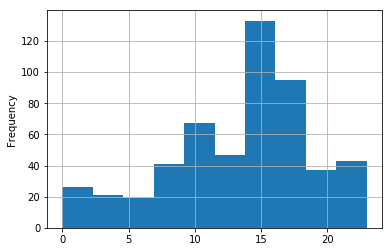

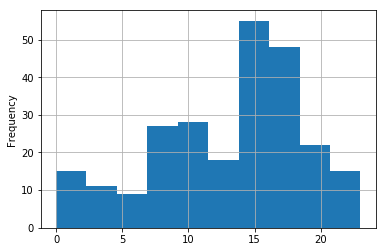

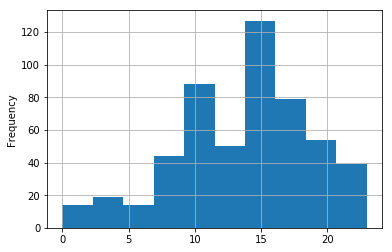

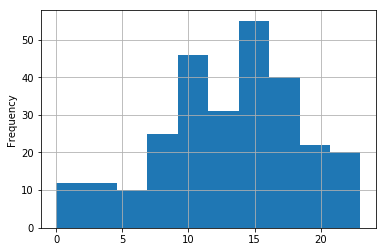

In [21]:
swing_types=['T','E','S','F']
for i in swing_types:
    tesf_waves['Time'].loc[tesf_waves['Swing_Type']==i].dt.hour.plot(kind='hist', grid=True)
    plt.show()
    plt.close()

Day of week doesn't matter, with possibly a tiny preference for Thursdays
This has some backing because of the conventional wisdom that Friday's tend to be faded
Thus if Friday forms the wick for the weekly candle and the next week continues moves in that direction
then Thursdays will mark more extremes

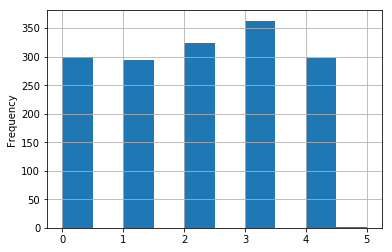

In [22]:
tesf_waves['Time'].dt.dayofweek.plot(kind='hist', grid=True)

In [23]:
#3) Charting
def df_time_to_plot(df,df_time_index):
    temp_ts=str(df.loc[df_time_index,'Time'].value)
    temp_ts=int(temp_ts[:10])
#     a,b,c,d=time.strftime("%Y,%m,%d,%H", time.localtime(temp_ts)).split(',')
    a,b,c,d=time.strftime("%Y,%m,%d,%H", time.gmtime(temp_ts)).split(',')
    a=int(a)
    b=int(b)
    c=int(c)
    d=int(d)
    return a,b,c,d

def list_split(input_list):
    output_list=[]
    for i,e in enumerate(input_list):
        if i < len(input_list)-1:
            output_list.append([e,input_list[i+1]])
    return output_list

        
def plot_info(df,pointa,pointb):
    a,b,c,d=df_time_to_plot(df,pointa)
    time_plot_one=dt.datetime(a,b,c,d)
    a,b,c,d=df_time_to_plot(df,pointb)
    time_plot_two=dt.datetime(a,b,c,d)
    if df.loc[pointa,'Fractal'] == 'U':
        price_one=df.loc[pointa,'High']
        price_two=df.loc[pointb,'Low']        
    else:
        price_one=df.loc[pointa,'Low']
        price_two=df.loc[pointb,'High']
#     plt.plot_date([time_plot_one,time_plot_two],[price_one,price_two],fmt='-',color='cyan')
    return time_plot_one,time_plot_two,price_one,price_two

def wave_chart(df,start,end,h1_wave_list,chart_date='Real',entry_lines='Off',extra_bars=0):
    false_date_df=pd.DataFrame()
    false_date_df.loc[0,'Date'],false_date_df.loc[0,'Open'],false_date_df.loc[0,'High'],false_date_df.loc[0,'Low'],false_date_df.loc[0,'Close']=[None,None,None,None,None]      
    
    adjusted_start=start-extra_bars
    adjusted_end=end+extra_bars
    
    for i in range(adjusted_end-adjusted_start+1):
        if chart_date == 'Real':
            false_date_df.loc[i,'Date']=df.loc[adjusted_start+i,'Time']
        else:
            false_date_df.loc[i,'Date']=datestack.loc[adjusted_start+i]
        false_date_df.loc[i,'Open']=df.loc[adjusted_start+i,'Open']
        false_date_df.loc[i,'High']=df.loc[adjusted_start+i,'High']
        false_date_df.loc[i,'Low']=df.loc[adjusted_start+i,'Low']
        false_date_df.loc[i,'Close']=df.loc[adjusted_start+i,'Close']
    
    false_date_df.Date = pd.to_datetime(false_date_df.Date)
    h1_wave_lines=list_split(h1_wave_list)

    for i in h1_wave_lines:
        a,b,c,d=plot_info(df,i[0],i[1])
#         print(a,b,c,d)
        plt.plot_date([a,b],[c,d],fmt='-',color='cyan')
    
    a,b,c,d=plot_info(df,start,end)
    plt.plot_date([a,b],[c,d],fmt='-',color='purple')
    plt.show()    
    return f1


In [24]:
wave_list[10:20]

[281, 297, 361, 374, 398, 403, 440, 447, 480, 492]

In [25]:
t_list=[361, 374, 398, 403, 440, 447]
wave_chart(h1,361,447,t_list)

NameError: name 'cci' is not defined